In [1]:
### Loading the required libraries 
import numpy as np
import pandas as pd
from pandas.core.common import flatten
np.random.seed(16) ## e.g., put seed=7 
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn 
device = torch.device('cpu') ## Running on cpu

# Appropriate projection modules are now loaded by the adversary objects themselves
#from projection import projection_simplex_bisection as proj ### loading the simplex projection module
#from projection import euclidean_projection as proj ### loading the Euclidean projection module
# We have taken projection on a Euclidean ball of radius R=10

## In the creditcard fraud detection problem, due to the extreme imbalance in the data, we have to take 
## a custom larger value of lambda (different from the general setting). This is because, due to extreme 
## imbalance, a violation bound, even of the order of O(sqrt{T}) is inadequate. 

In [2]:
class COCO:
    def __init__(self, n, T): ### n denotes the dimension of input
        #self.D=np.sqrt(2) ### D denotes the Euclidean diameter of the feasible set, which is sqrt(2) for simplex
        self.D=10 ### Diameter of the action set
        self.n=n 
        self.x=np.array(proj(np.random.rand(n))).reshape(-1,1) ### n denotes the input dimension
        #self.x=np.array(proj(np.ones(n)/n)).reshape(-1,1)
        self.step_size=0
        self.grad_sum_sq=0.001 ### internal variable needed to compute the step size
        self.sum_x=self.x ### internal variable required to get the average prediction
        self.Q=0 ### initializing the cumulative constraint violation
        self.TotalCost=0 ### initializing the total cost incurred
        #self.Lambda=1.0/(2*np.sqrt(T)) ## the default setting
        self.Lambda=0.025 ## custom setting for the credit card fraud detection dataset
        self.V=1   ## setting the required parameters
    
        
        
        
    def predict_COCO(self, grad):
        self.x=np.array(proj(self.x-self.step_size*grad)).reshape(-1,1)
        return
    
    def update_COCO(self, cost_val, constr_val):
        self.Q = self.Q+constr_val
        self.TotalCost=self.TotalCost+cost_val ## updating CCV and cost
        self.sum_x=self.sum_x+self.x
    
    def surrogate_cost_grad(self, cost_grad, constr_grad): # returns the gradient of the surrogate cost function at x
        grad=self.V*cost_grad.reshape(-1,1)+self.Lambda*np.exp(self.Lambda*self.Q)*constr_grad.reshape(-1,1)
        self.grad_sum_sq=self.grad_sum_sq+np.linalg.norm(grad)**2
        self.step_size=self.D/np.sqrt(2.0*self.grad_sum_sq) ### selecting step sizes using AdaGrad
        return grad.reshape(-1,1)
        
        
    
        

In [3]:
class Adversary_2Player:
    
    def __init__(self, n): # we are considering the single constraint case, i.e., m=1
        self.n=n
        self.id='2Player'
        self.problem_class='game'
        self.A=np.random.randn(n,n)
        self.C_x=np.random.rand(n,1)
        self.C_y=0.5*np.random.rand(n,1)  ## forcing a strict feasibility on every round
        self.cost_grad_sum=np.zeros([n,1]) ## state variable used to compute regret
    
    def grad_f(self, x):
        best_action=np.argmax((self.A.T)@x) # computes the current best action of the adversary
        self.cost_grad_sum+=self.A[:,best_action].reshape(-1,1) # updating the sum of gradients of cost
        return self.A[:,best_action].reshape(-1,1) # returns a column vector
    
    def f_val(self, x):
        best_action=np.argmax((self.A.T)@x) # computes the current best action of the adversary
        return (x.T@self.A[:,best_action])
    
    def grad_g(self, x):
        best_action=np.argmax((self.A.T)@x) # computes the current best action of the adversary
        if self.C_x.T@x+self.C_y[best_action]-1>0:
            return self.C_x.reshape(-1,1)
        else:
            return np.zeros([int(self.n),1])
    
    def g_val(self,x):
        best_action=np.argmax((self.A.T)@x) # computes the current best action of the adversary
        return(max(0,self.C_x.T@x+self.C_y[best_action]-1))

In [4]:
class Adversary_Test:
### solving the following offline optimization problem
### https://www.wolframalpha.com/input?i=minimize+e%5Ex%2By%5E2%2C+s.t.+x%2By%3D1%2C+x%3E%3D0%2C+y%3E%3D0%2C+x%5E2%2B2.5*y%5E2%3C%3D1
    def __init__(self,n):
        self.n=n
        self.problem_class='Test'
        self.id='Test'

        
    def grad_f(self, x):
        return np.array([np.exp(x[0]), 2*x[1]]).reshape(-1,1)
    
    def grad_g(self, x):
        if x[0]**2+2.5*x[1]**2-1>=0:
            return np.array([2.0*x[0], 5*x[1]]).reshape(-1,1)
        else:
            return np.zeros([self.n,1])
                             
    def f_val(self,x):
        return (np.exp(x[0])+x[1]**2)
                             
    def g_val(self, x):
        return max(0, x[0]**2+2.5*x[1]**2-1)
        

In [5]:
class Adversary_classification:
    
    def __init__(self):
        self.problem_class='classification'
        self.t=-1 ### counter indicates the current round number
        self.MISS=0 ## counter to keep track of number of misses
        self.N1=0 ## count of examples belonging to class 1
        self.FA=0 ### counter to keep track of number of FA
        self.N0=0 ## count of examples belonging to class 0
        
    
    def grad_f(self, x):
        self.t+=1 # the counter is incremented when a call to grad_f is made
        hat_y=float(1.0/(1+np.exp(self.z[self.t,:]@x))) # computing the predicted value
        return (-(1-self.y[self.t])*(hat_y)*self.z[self.t,:]).reshape(-1,1) ## computing from f defined below
        
    
    def grad_g(self, x):
        hat_y=float(1.0/(1+np.exp(self.z[self.t,:]@x))) # computing the predicted value
        return (self.y[self.t]*(1-hat_y)*self.z[self.t,:]).reshape(-1,1) ## computing from g defined below
        
    
    def f_val(self, x):
        hat_y=float(1.0/(1+np.exp(self.z[self.t,:]@x))) # computing the predicted value
        self.N0+=(1-self.y[self.t])
        self.FA+=(1-self.y[self.t])*hat_y
        self.N1+=self.y[self.t]
        self.MISS+=self.y[self.t]*(1-hat_y)
        return -(1-self.y[self.t])*np.log(1-hat_y) ## f= -(1-y)log(1-y_hat) (ML est)
    
    def g_val(self, x):
        bias=np.log(0.999999) ## can make bias=0
        hat_y=float(1.0/(1+np.exp(self.z[self.t,:]@x))) # computing the predicted value
        return -self.y[self.t]*(np.log(hat_y)-bias) ## g = -y * (log(y_hat) - log(target_prob) (ML est)
    
    

In [6]:
class Banknote(Adversary_classification):
    def __init__(self):
        super().__init__()
        self.id='banknote'
        self.data=pd.read_csv('data/data_banknote_authentication.txt')
        self.data.columns=['variance', 'skewness', 'curtosis', 'entropy', 'label']
        self.data=self.data.sample(frac=1) ## randomly shuffling the rows
        
        self.z=np.array(self.data.iloc[:,0:4]) ## z denotes the feature vector matrix
        ### appending an all-one column to account for the intercept term
        #l=pd.DataFrame(np.ones(len(self.data)))
        #self.z=np.append(self.z, l, axis=1)
        
        
        object= StandardScaler()
        self.z= object.fit_transform(self.z) ## preprocessing the feature vectors 
        self.y=np.array(self.data['label'])    ## y denotes the column of labels
    

In [7]:
class LinearSep(Adversary_classification):
    def __init__(self):
        super().__init__()
        self.id='linsep'
        self.data=pd.read_csv('data/large_linearly_separable_data.csv')
        self.data=self.data.sample(frac=1) ## randomly shuffling the rows
        self.z=np.array(self.data.iloc[:,0:2]) ## z denotes the feature vector matrix
        ### appending an all-one column to account for the intercept term
        #l=pd.DataFrame(np.ones(len(self.data)))
        #self.z=np.append(self.z, l, axis=1)
        
        
        object= StandardScaler()
        self.z= object.fit_transform(self.z) ## preprocessing the feature vectors 
        self.y=np.array(self.data['Label'])    ## y denotes the column of labels

In [8]:
class IrisDataset(Adversary_classification):
    def __init__(self):
        super().__init__()
        self.id='iris'
        self.data=pd.read_csv('data/Iris.csv')
        self.data=self.data.replace('Iris-setosa', 0)
        self.data=self.data.replace('Iris-versicolor', 1)
        self.data=self.data.replace('Iris-virginica', 2)
        self.data=self.data[self.data['Species']<1.5]
        
        self.data=self.data.sample(frac=1) ## randomly shuffling the rows
        self.z=np.array(self.data.iloc[:,1:5]) ## z denotes the feature vector matrix
        ### appending an all-one column to account for the intercept term
        #l=pd.DataFrame(np.ones(len(self.data)))
        #self.z=np.append(self.z, l, axis=1)
        
        
        object= StandardScaler()
        self.z= object.fit_transform(self.z) ## preprocessing the feature vectors 
        self.y=np.array(self.data['Species'])    ## y denotes the column of labels

In [9]:
class NN: 
    ## implements the case when the cost and constraint functions are given by a DNN
    def __init__(self):
        self.id='NN'
        self.problem_class='classification'
        self.t=-1 ### counter indicates the current round number
        self.MISS=0 ## counter to keep track of number of misses
        self.N1=0 ## count of examples belonging to class 1
        self.FA=0 ### counter to keep track of number of FA
        self.N0=0 ## count of examples belonging to class 0
        
        ## loading data
        ## Linearly separable data
        ##---------------
        #self.data=pd.read_csv('data/large_linearly_separable_data.csv') ## recommended R=10
        #self.data=self.data.sample(frac=1) ## randomly shuffling the rows
        #self.z=np.array(self.data.iloc[:,0:2]) ## z denotes the feature vector matrix
        #self.y=np.array(self.data['Label'])    ## y denotes the column of labels
        
        ##----------------
        ## Credit card fraud detection data (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
        ##
        
        self.data=pd.read_csv('/Users/abhishek/Desktop/Research/datasets/data/creditcard.csv')
        self.data=self.data.sample(frac=1) ## randomly shuffling the rows
        self.z=np.array(self.data.iloc[:,1:30]) ## z denotes the feature vector matrix
        self.y=np.array(self.data['Class'])    ## y denotes the column of labels
        
        ##--------------------
        
        object= StandardScaler()
        self.z= object.fit_transform(self.z) ## preprocessing the feature vectors 
        
        #### -------------
        ## configuring the NN architecture and the loss function
        
        self.N, self.D_in, self.H, self.D_out = 1, self.z.shape[1], 10, 1 ## 100 hidden layer width, 4 dimensional feature
        
        self.model = torch.nn.Sequential(
          torch.nn.Linear(self.D_in, self.H),
          torch.nn.ReLU(),
          torch.nn.Linear(self.H, self.D_out),
          torch.nn.Sigmoid(), ## the output layer
        ).to(device)
        
        self.loss_fn = torch.nn.BCELoss() ## remember - it is simply the negative log likelihood - training via Max likelihood
        
    def update_grad(self):
        self.t+=1
        self.model.zero_grad()
        self.hat_y=self.model(torch.tensor(self.z[self.t,:]).to(torch.float32)) ## predicted value 
        self.hat_y=torch.clamp(self.hat_y, min=1e-7, max=1-1e-7) ## avoiding extreme values for numerical stability
        self.loss=self.loss_fn(torch.squeeze(self.hat_y), torch.tensor(self.y[self.t]).to(torch.float32))
        self.loss.backward()
        gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                gradients.append(param.grad.view(-1))
        self.grad_vector = np.array(torch.cat(gradients))
        
        ## Updating the performance metrics
        self.N0+=(1-self.y[self.t])
        self.FA+=(1-self.y[self.t])*self.hat_y
        self.N1+=self.y[self.t]
        self.MISS+=self.y[self.t]*(1-self.hat_y)
        
        
    def grad_f(self, x):
        if(self.y[self.t]==0):
            return self.grad_vector
        else:
            return np.zeros(len(self.grad_vector))
        
    
    def grad_g(self, x):
        if(self.y[self.t]==1):
            return self.grad_vector
        else:
            return np.zeros(len(self.grad_vector))
        
        
    
    def f_val(self, x):
        return -(1-self.y[self.t])*torch.log(1.0-self.hat_y) ## f= -(1-y)log(1-y_hat) (Liklihood value)
    
    
    def g_val(self, x):  ## g = -y log(y_hat) assuming bias=0
        return -self.y[self.t]*(torch.log(self.hat_y)-torch.log(torch.tensor(1.0)))
    
    

## Assigning the parameters returned by COCO to the NN
def assign_parameters(model, vector):
    """
    Assign the parameters of a PyTorch neural network using the given vector.

    Args:
    - model (nn.Module): The PyTorch neural network model.
    - vector (list or numpy array or torch tensor): The vector containing the new parameters.

    Returns:
    - None
    """
    if not isinstance(vector, torch.Tensor):
        vector = torch.tensor(vector, dtype=torch.float32)
    
    # Ensure the vector has the same number of elements as the model's parameters
    params = torch.cat([p.view(-1) for p in model.model.parameters()])
    assert params.numel() == vector.numel(), "Vector size must match the number of model parameters"
    
    # Assign the parameters
    index = 0
    for p in model.model.parameters():
        numel = p.numel()
        p.data = vector[index:index+numel].view(p.size())
        index += numel


### Best result : 20 hidden layers, lambda = 0.025 
## False Alarm rate: tensor([0.3192], grad_fn=<DivBackward0>) Miss rate: tensor([0.1397], grad_fn=<DivBackward0>)


In [10]:
### Driver code
#---------------------------

## Choosing the problem instance

#adversary= Adversary_Test(n) ### Adversary object
#adversary=Banknote()
#adversary=LinearSep()
#adversary=Adversary_2Player(n=100)
#adversary=IrisDataset()
adversary=NN()

if adversary.id=='2Player':
    n=100
    T=100000
    from projection import projection_simplex_bisection as proj ### loading the simplex projection module
elif adversary.id=='banknote':
    T, n=adversary.z.shape
    from projection import euclidean_projection as proj ### loading the Euclidean projection module
elif adversary.id=='linsep':
    T, n=adversary.z.shape
    from projection import euclidean_projection as proj ### loading the Euclidean projection module
elif adversary.id=='iris':
    T, n=adversary.z.shape 
    from projection import euclidean_projection as proj ### loading the Euclidean projection module
elif adversary.id=='NN':
    T=adversary.z.shape[0]
    grad_vec=[]
    for param in adversary.model.parameters():
        grad_vec.append(np.array(param.data))
    n=len(list(flatten(grad_vec))) ## counting the number of parameters
    from projection import euclidean_projection as proj ### loading the Euclidean projection module
##########################if 


coco = COCO(n,T) ### Algorithm object


cost_vec=np.zeros([1,T])
violation_vec=np.zeros([1,T]) ### Arrays to store the cumulative cost and violation incurred by COCO
regret_vec=np.zeros([1,T])

for t in range(T):
    current_action=coco.x # getting the current action of the algorithm
    
    ## assigning the parameters to the NN object 
    
    if adversary.id=='NN':
        assign_parameters(adversary, current_action)
        adversary.update_grad()
        
    ## Calling adversary to get its choice of cost and constraint functions    
    cost_grad=adversary.grad_f(current_action)
    constr_grad=adversary.grad_g(current_action)
    cost_val=adversary.f_val(current_action)
    constr_val=adversary.g_val(current_action)  ### getting adversary's choices
    #print((1-adversary.y[adversary.t])*np.count_nonzero(cost_grad+constr_grad))
    #print(adversary.hat_y)
    #print(np.linalg.norm(coco.x))
    #print(adversary.z[adversary.t])
    #print(cost_val)
    
    if adversary.id=='NN':
        constr_val=constr_val.item()
    
    ## Calling COCO to update its internal states and to determine its next action
    coco.update_COCO(cost_val, constr_val) ### updating internal states of the algorithm
    surrogate_cost_grad=coco.surrogate_cost_grad(cost_grad, constr_grad) ### computing the gradient of the surrogate cost
    
    coco.predict_COCO(surrogate_cost_grad)  ### predicting the next_action
    
    #### recording the statistics
    cost_vec[0,t]=coco.TotalCost
    violation_vec[0,t]=coco.Q
    if adversary.problem_class=='game':
        regret_vec[0,t]=coco.TotalCost - min(adversary.cost_grad_sum) ## this is a little erroneous as it computes regret over the entire admissible set
   
 #### computing the number of classification errors
if adversary.problem_class=='classification':
    print('False Alarm rate:',  adversary.FA/adversary.N0, 'Miss rate:', adversary.MISS/adversary.N1)


False Alarm rate: tensor([0.3249], grad_fn=<DivBackward0>) Miss rate: tensor([0.1400], grad_fn=<DivBackward0>)


In [11]:
## plotting the results
#import pylab 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
#sns.set(style='ticks', palette='Set2')
sns.set()

sns.set_theme("paper")
sns.set_style("dark")
#sns.color_palette("gist_heat")

#ax = plt.plot(figsize=(10,6))
#pylab.figure(1)
#pylab.plot(range(T), violation_vec.T)
#pylab.figure(2)
#pylab.plot(range(T), regret_vec.T)

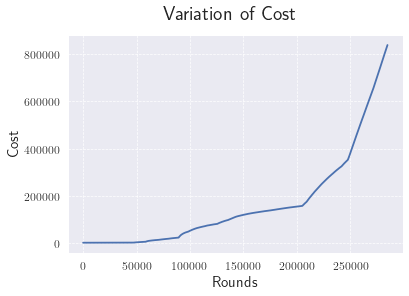

In [12]:
#pylab.figure(2)
#pylab.plot(range(T), cost_vec.T)
#sum(coco.x)
#plt.figure(dpi=1000)
plt.ylabel("Cost", fontsize=15)
plt.xlabel("Rounds", fontsize=15)
plt.plot(range(T), cost_vec.T, linewidth = 1.8)
plt.grid(linestyle = '--', linewidth = 0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle('Variation of Cost', fontsize=20)
plt.savefig('Cost_variation_plt', dpi=1000)

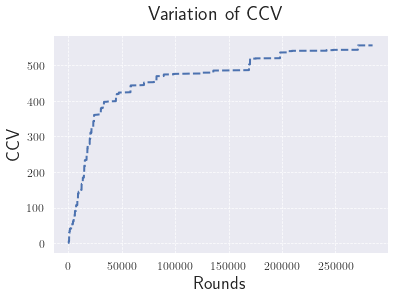

In [13]:
#plt.figure(dpi=1000)
plt.ylabel("CCV", fontsize=18)
plt.xlabel("Rounds", fontsize=18)
plt.plot(range(T), violation_vec.T, linewidth = 2, linestyle='--')
plt.grid(linestyle = '--', linewidth = 0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.suptitle('Variation of CCV', fontsize=20)
plt.savefig('CCV_variation_plt', dpi=1500)

In [14]:
coco.grad_sum_sq

1719143754767.7634

In [15]:
coco.Q

556.3888996376734

In [16]:
coco.TotalCost

tensor([839428.1250], grad_fn=<AddBackward0>)

In [17]:
## Debugging the code
#adversary=NN()
#grad_vec=[]
#for param in adversary.model.parameters():
#    grad_vec.append(np.array(param.data))
#n=len(list(flatten(grad_vec)))
#from projection import euclidean_projection as proj
#T=adversary.z.shape[0]
#coco = COCO(n,T) ### Algorithm object
#x=coco.x
#list(adversary.model.parameters())[0].data
#x=coco.x
#list(adversary.model.parameters())[0].data
#adversary.model(torch.tensor(adversary.z[adversary.t,:]).to(torch.float32)) ## predicted value
#adversary.update_grad()
#torch.tensor(adversary.y[adversary.t]).to(torch.float32)
#adversary.loss_fn(adversary.hat_y, torch.tensor(adversary.y[adversary.t]).to(torch.float32))

In [18]:
#adversary.loss_fn(adversary.hat_y, torch.tensor(adversary.y[adversary.t]).to(torch.float32))